In [3]:
# Step 1. Loading the Data and required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Load the dataset
file_path = "/home/guilherme/Documents/Github/Tese/Documentation/Dataset_Augmentation/Augmented_database_29_09_2023.xlsx"
df = pd.read_excel(file_path, sheet_name="Augmented Data")


In [4]:
# Step 2. Data Transformation and Encoding

# Replace NaN with 'None' placeholder
symptom_cols = [f'Symptom_{i}' for i in range(1, 26)]
df[symptom_cols] = df[symptom_cols].fillna('None')
df['symptoms'] = df[symptom_cols].apply(lambda row: [symptom for symptom in row if symptom != 'None'], axis=1)

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['symptoms'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['ICD 11'])

In [5]:
# Step 3. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Introducing SMOTE
smote = SMOTE(k_neighbors=4, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
# Step 4: Hyperparameter tunning

# Import the necessary libraries
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import shap

# Calculate the number of classes
n_classes = len(np.unique(y))

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('input_units', min_value=256, max_value=1024, step=256),
                    activation='relu',
                    input_shape=(X_train_resampled.shape[1],)))

    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'hidden_units_{i}', min_value=128, max_value=512, step=128),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparam_search',
    project_name='disease_prediction'
)

# Search for the best model
tuner.search(X_train_resampled, y_train_resampled, epochs=10, validation_split=0.2)

# Get the best hyperparameters and build the model
best_hyperparameters = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hyperparameters)

model.summary()


Trial 10 Complete [00h 01m 06s]
val_accuracy: 0.9995833337306976

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 06m 42s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              803840    
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 300)               38700     
                                                                 
Total params: 973740 (3.71 MB)
Trainable params: 973740 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
## Step 5. Training the Model

history = model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
150/150 [==============================] - 2s 12ms/step - loss: 3.1709 - accuracy: 0.5679 - val_loss: 0.9851 - val_accuracy: 0.8992
Epoch 2/20
150/150 [==============================] - 2s 12ms/step - loss: 0.1825 - accuracy: 0.9806 - val_loss: 0.0671 - val_accuracy: 1.0000
Epoch 3/20
150/150 [==============================] - 2s 12ms/step - loss: 0.0429 - accuracy: 0.9971 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 4/20
150/150 [==============================] - 2s 12ms/step - loss: 0.0190 - accuracy: 0.9994 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 5/20
150/150 [==============================] - 2s 12ms/step - loss: 0.0126 - accuracy: 0.9998 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 6/20
150/150 [==============================] - 2s 12ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 7/20
150/150 [==============================] - 2s 12ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000

In [10]:
from sklearn.metrics import classification_report, accuracy_score

# Step 6. Evaluating the Model

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))

print(f"Accuracy of the model: {accuracy * 100:.2f}%")

# Predict class labels for the test set
y_pred_probabilities = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Ensure all classes are accounted for in the classification report
all_classes = np.arange(len(label_encoder.classes_))
report = classification_report(y_test, y_pred_classes, labels=all_classes, target_names=label_encoder.classes_)
print(report)



38/38 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.9992
Accuracy of the model: 99.92%
38/38 [==============================] - 0s 3ms/step
               precision    recall  f1-score   support

       1A07.Y       1.00      1.00      1.00         3
       1A40.0       1.00      1.00      1.00         2
       1A40.Z       1.00      1.00      1.00         4
         1A6Z       1.00      1.00      1.00         3
      1A70.0Y       1.00      1.00      1.00         3
       1A70.Y       1.00      1.00      1.00         4
         1A80       1.00      1.00      1.00         4
         1A81       1.00      1.00      1.00         4
         1A91       1.00      1.00      1.00         4
         1A92       1.00      1.00      1.00         6
       1A94.1       1.00      1.00      1.00         6
      1B12.40       1.00      1.00      1.00         3
       1B40.Z       1.00      1.00      1.00         3
       1B71.Z       1.00      1.00      1.00         3
    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


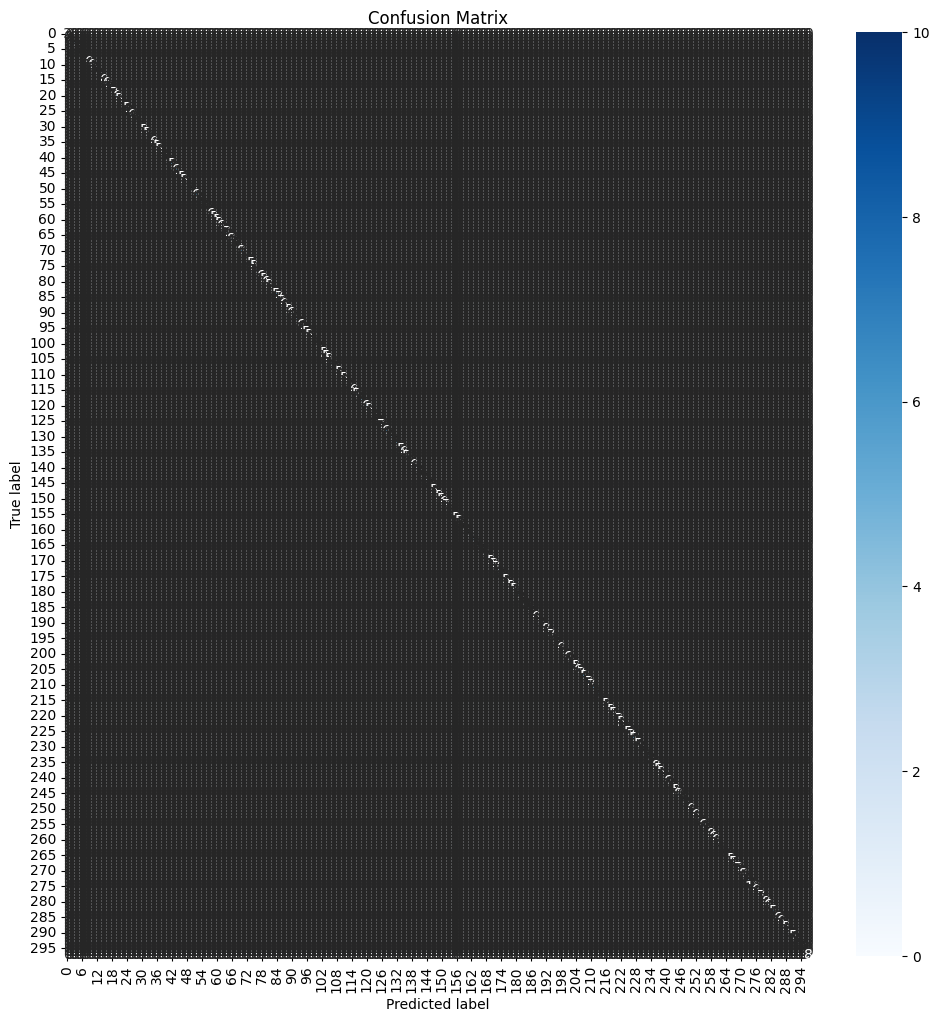

In [11]:
# Confusion Matrix Visualization

conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt="d",
            cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


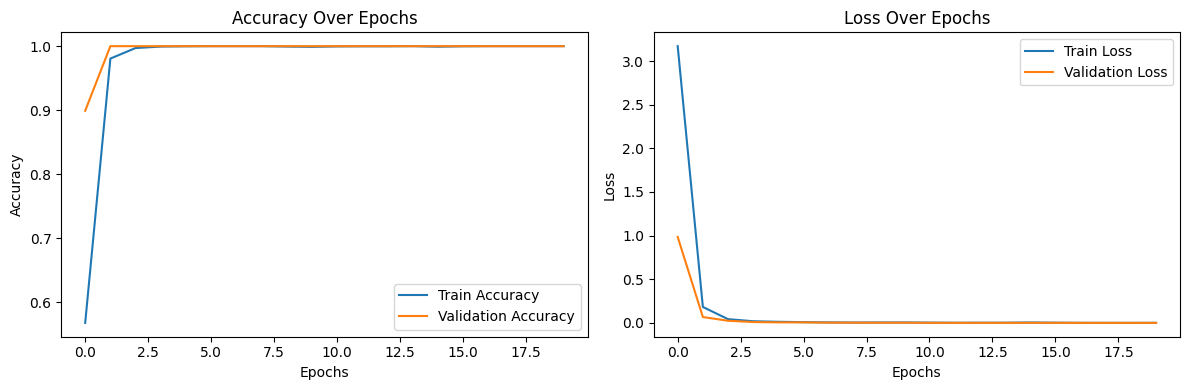

In [12]:
## 7. Visualization

# We can also visualize the training progress.

import matplotlib.pyplot as plt

# Plotting accuracy and loss over epochs
plt.figure(figsize=(12, 4))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()
plt.title('Accuracy Over Epochs')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()


In [13]:
# Step 7: Model Deployment
import joblib

# Save the model, label encoder, and binarizer for later use
model_filename = 'NN_no_features.pkl'
label_encoder_filename = 'no_features_label_encoder.pkl'
binarizer_filename = 'no_features_symptoms_binarizer.pkl'

joblib.dump(model, model_filename)
joblib.dump(label_encoder, label_encoder_filename)
joblib.dump(mlb, binarizer_filename)

loaded_model = joblib.load(model_filename)
loaded_label_encoder = joblib.load(label_encoder_filename)
loaded_binarizer = joblib.load(binarizer_filename)

In [14]:
# Step 8: Disease prediction

def predict_disease(symptoms_list, top_n=2):
    """
    Given a list of symptoms (ICD-11 codes), predict the top potential diseases along with their confidence.
    """
    # Transform the symptoms list into the appropriate binary vector format
    symptoms_encoded = mlb.transform([symptoms_list])  # `mlb` was previously used for multilabel binarization

    # Predict the probability distribution over classes using the trained model
    disease_probabilities = loaded_model.predict(symptoms_encoded)

    # Get indices of the top_n classes
    top_indices = np.argsort(disease_probabilities[0])[-top_n:][::-1]

    # Decode these indices to get the actual disease codes
    top_diseases = label_encoder.inverse_transform(top_indices)
    
    # Extract their corresponding probabilities
    top_probabilities = disease_probabilities[0][top_indices]

    return list(zip(top_diseases, top_probabilities))

# Test the prediction function
sample_symptoms = ['MC15', '9D9Z', '9D90.6', '9C80.0', 'LD20.4', '8A68.Z', '9B73.3', '9B65.2', '1D01.Y', 'MA01.Z'] # 1F57.Z	Toxoplasmosis
predicted_diseases_with_confidence = predict_disease(sample_symptoms)

for disease, confidence in predicted_diseases_with_confidence:
    print(f"Disease: {disease} with confidence: {confidence*100:.2f}%")

1/1 [==============================] - 0s 47ms/step
Disease: 1F57.Z with confidence: 100.00%
Disease: 8E41 with confidence: 0.00%


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the feature names
feature_names = mlb.classes_

# Get the encoding for sample symptoms
new_symptoms_encoded = mlb.transform([sample_symptoms])

# Initialize the SHAP GradientExplainer with training data and compute SHAP values for test data
explainer = shap.GradientExplainer(model, X_train_resampled[:100])
shap_values = explainer.shap_values(new_symptoms_encoded)

# If SHAP values are in the form of tf.Tensor, convert them to numpy arrays
shap_values = [s.numpy() if isinstance(s, tf.Tensor) else s for s in shap_values]
shap.initjs()

# Fetch indices for the sample symptoms
new_symptoms_indices = [all_possible_symptoms.tolist().index(symptom) for symptom in sample_symptoms]


# Loop over the predicted diseases
for disease, _ in predicted_diseases_with_confidence:
    transformed_label = label_encoder.transform([disease])[0]
    print(f"Transformed label for {disease}:", transformed_label)

    class_shap_values = shap_values[transformed_label]

    # Filter class_shap_values based on sample_symptoms
    filtered_shap_values = class_shap_values[0, new_symptoms_indices].reshape(1, -1)
    filtered_symptoms = np.array(all_possible_symptoms)[new_symptoms_indices]

    # Adjust the figure size and plot
    plt.figure(figsize=(10, 15))
    shap.summary_plot(filtered_shap_values, filtered_symptoms, color="#90EE90", plot_type="bar", title=f"SHAP values for {disease}")

    plt.show()


In [ ]:

# Loop over the predicted diseases
for disease, _ in predicted_diseases_with_confidence:
    transformed_label = label_encoder.transform([disease])[0]
    print(f"Transformed label for {disease}:", transformed_label)
    
    class_shap_values = shap_array[transformed_label]
    
    # Filter class_shap_values based on sample_symptoms
    filtered_shap_values = class_shap_values[0, new_symptoms_indices].reshape(1, -1)
    filtered_symptoms = np.array(all_possible_symptoms)[new_symptoms_indices]
    
    # Get feature values for color
    feature_values = new_symptoms_encoded[0, new_symptoms_indices].reshape(1, -1)
    
    # Adjust the figure size and plot with the color bar
    plt.figure(figsize=(10, 15))
    shap.summary_plot(filtered_shap_values, feature_names=filtered_symptoms, title=f"SHAP values for {disease}")



In [ ]:

feature_names = mlb.classes_

explainer = shap.GradientExplainer(model, X_train_resampled[:100])
shap_values = explainer.shap_values(X_test[0:1])

# Compute expected_value
expected_value = model.predict(X_train_resampled[:100]).mean()

shap_values = [s.numpy() if isinstance(s, tf.Tensor) else s for s in shap_values]
shap.initjs()

# This gets the first set of shap values (for the first instance)
single_shap_values = shap_values[0][0] if isinstance(shap_values[0], list) else shap_values[0]

print("Type of expected_value:", type(expected_value))
print("Value of expected_value:", expected_value)
print("Shape of single_shap_values:", np.shape(single_shap_values))
# print("First few elements of single_shap_values:", single_shap_values[:5])

# shap.force_plot(expected_value, single_shap_values, X_test[0:1], feature_names=mlb.classes_)


In [ ]:
# print(shap_values[i].shape)
print(X_test.shape)
print(mlb.classes_[:5])

first_instance = X_test[0]
# Reshape the first_instance to make it 2D
reshaped_instance = first_instance.reshape(1, -1)
decoded_features = mlb.inverse_transform(reshaped_instance)[0]
print(decoded_features)


first_corresponding_value = y_test[0]
first_corresponding_value_decoded = label_encoder.inverse_transform([first_corresponding_value])
print(first_corresponding_value_decoded)



# print("First instance from X_test:", first_instance)
# print("Corresponding value from y_test:", first_corresponding_value)


# Calculate SHAP values for a larger subset or the entire test dataset
for i in range(5): # First 5 instances of the test set# n_classes
  # shap.summary_plot(shap_values[i], X_test[i].reshape(1, -1), feature_names=mlb.classes_, title=f"Class {i} - SHAP Summary")
  print (y_test[i])
  shap.summary_plot(shap_values[i], X_test[i].reshape(1, -1), feature_names=mlb.classes_, title=f"Class {label_encoder.inverse_transform([i])[0]} - SHAP Summary")
